## Modeling 

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

import itertools
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier


In [32]:
data_dir = os.path.abspath(os.path.join('..', 'data'))
data = pd.read_csv(os.path.join(data_dir,'train.csv'))
data_dict = pd.read_csv(os.path.join(data_dir,'data_dictionary.csv'))
test_data = pd.read_csv(os.path.join(data_dir,'test.csv'))

In [33]:
# Saving test ids to a list to build test subsmissions after model.predict is run
test_ids = test_data["id"].tolist()

## EDA


Missing values after handling:
 Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                                404
CGAS-CGAS_Score                            406
Physical-Season                            147
Physical-BMI                               216
Physical-Height                            213
Physical-Weight                            171
Physical-Waist_Circumference              2268
Physical-Diastolic_BP                      267
Physical-HeartRate                         258
Physical-Systolic_BP                       267
Fitness_Endurance-Season                  1492
Fitness_Endurance-Max_Stage               2022
Fitness_Endurance-Time_Mins               2025
Fitness_Endurance-Time_Sec                2025
FGC-Season                                  92
FGC-FGC_CU                                 824
FGC-FGC_CU_Zone                            859
FGC-FGC_GSND               

/var/folders/v0/2007wxh55g36b3q98l1__pyh0000gn/T/ipykernel_99357/2715494289.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, test_data])


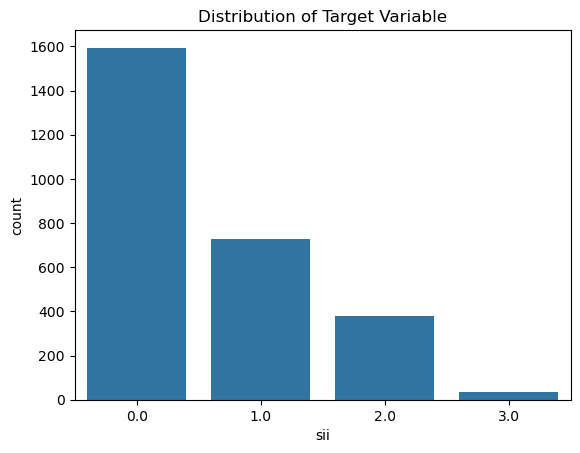

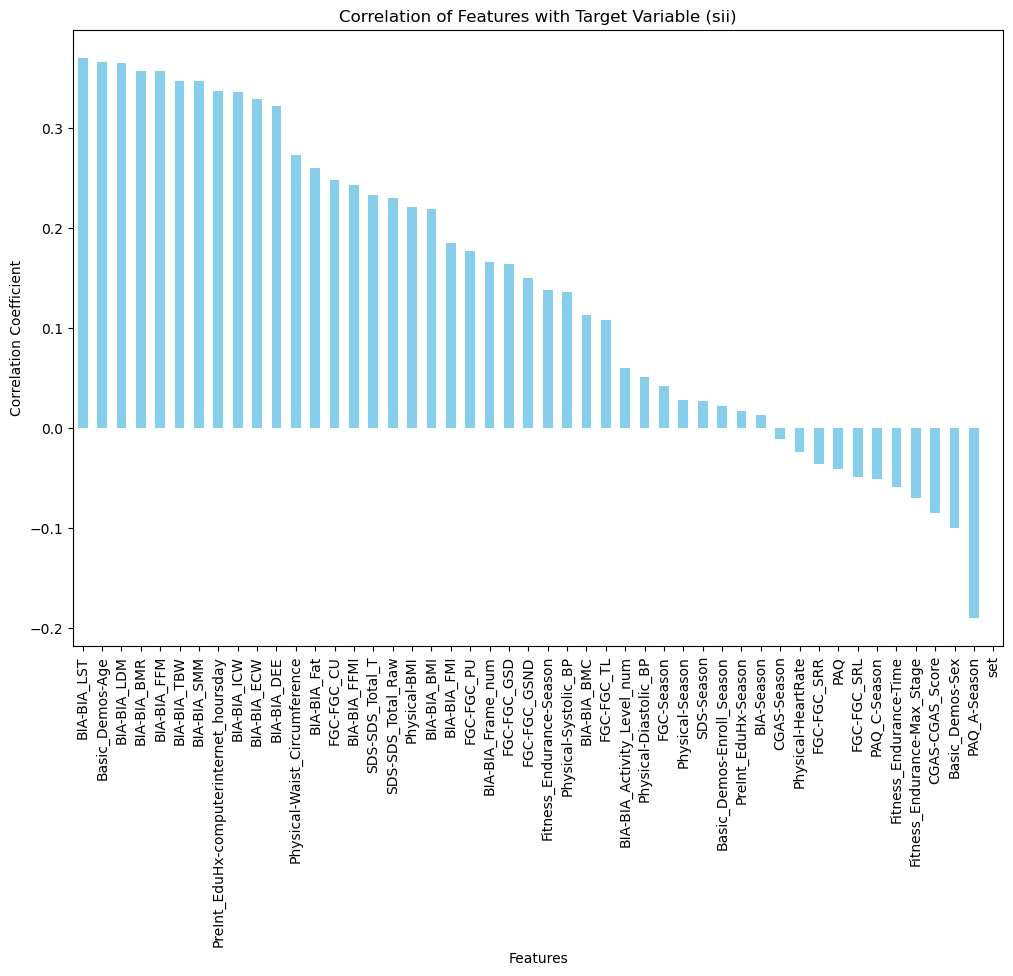

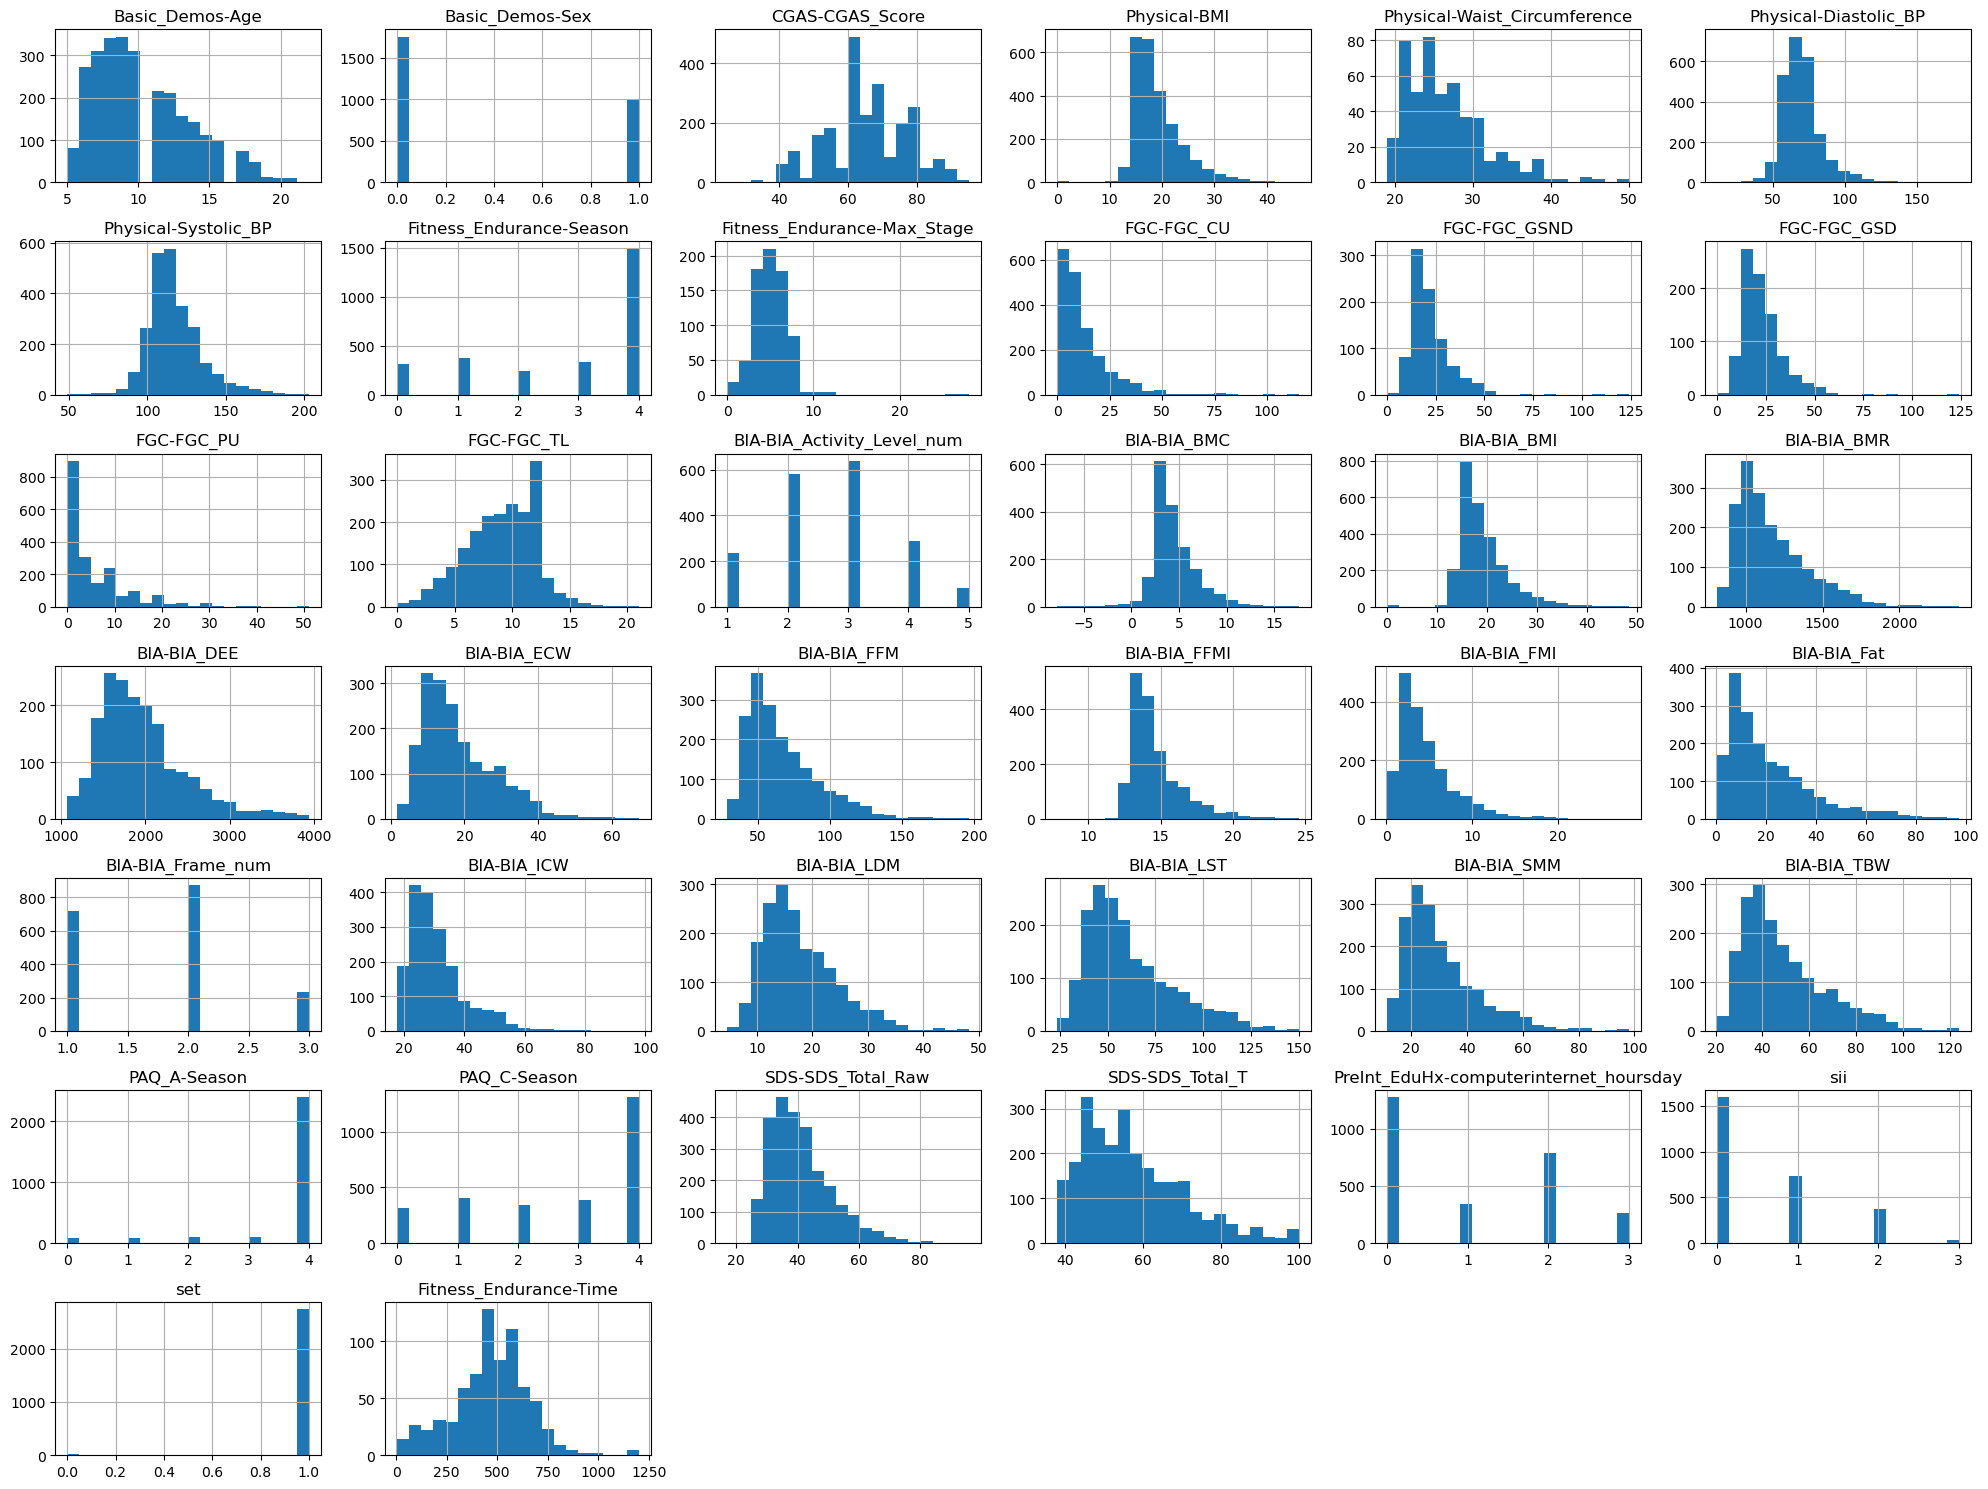

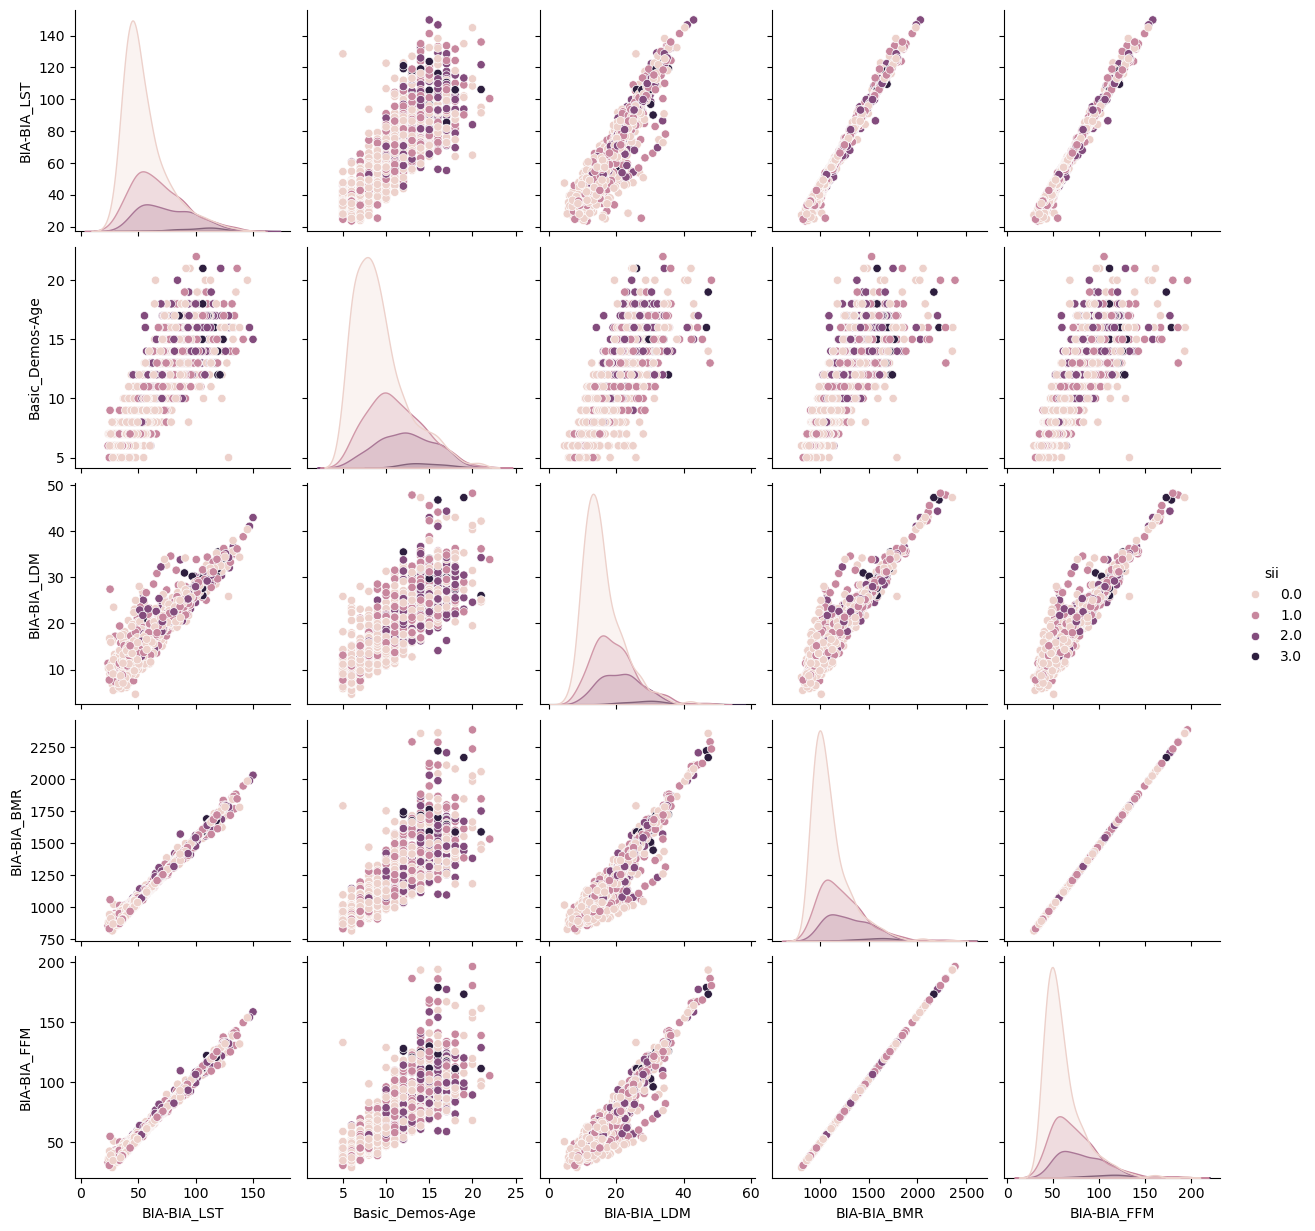

In [34]:
# Step 3: Basic EDA
# Drop the 'id' column if it exists since it is not useful for analysis or modeling
if 'id' in data.columns:
    data = data.drop(columns=['id'])

# Drop PCIAT columns as they are the actual test and answers
drop_columns = [col for col in data.columns if col.startswith('PCIAT')]
data = data.drop(columns=drop_columns)

# Drop rows with missing target values
data = data.dropna(subset=['sii'])

#Appending test_data to data so that it goes through the same data pre-processing
test_data = test_data[data.drop("sii",axis=1).columns]

data["set"] = "train"
test_data["set"] = "test"
test_data["sii"] = None

# Concating train and test together for imputing
data = pd.concat([data, test_data])
data = data.reset_index(drop=True)

# Verify that there are no more missing values
print("\nMissing values after handling:\n", data.isnull().sum())

# combined fitness endurance time column
data["Fitness_Endurance-Time_Sec"].fillna(0)
data["Fitness_Endurance-Time"] = 60*data["Fitness_Endurance-Time_Mins"] + \
    data["Fitness_Endurance-Time_Sec"]
data.drop(columns=["Fitness_Endurance-Time_Mins","Fitness_Endurance-Time_Sec"],inplace=True)

# combined PAQ: usually only child or adult filled in, so make a combined column
data['PAQ'] = data['PAQ_A-PAQ_A_Total'].fillna(data['PAQ_C-PAQ_C_Total'])
data.drop('PAQ_A-PAQ_A_Total',axis=1,inplace=True)
data.drop('PAQ_C-PAQ_C_Total',axis=1,inplace=True)

# fix BIA outliers
# note: reasonable values were determined by looking at histogram plots of the fields,
# for various bin sizes until it was apparent which were outliers
# extension: use outlier detection algorithm instead of hand-crafted cutoffs
data['BIA-BIA_BMC'] = data['BIA-BIA_BMC'].mask(data['BIA-BIA_BMC'] > 20, pd.NA)
data['BIA-BIA_BMR'] = data['BIA-BIA_BMR'].mask(data['BIA-BIA_BMR'] > 2500, pd.NA)
data['BIA-BIA_DEE'] = data['BIA-BIA_DEE'].mask(data['BIA-BIA_DEE'] > 4000, pd.NA)
data['BIA-BIA_ECW'] = data['BIA-BIA_ECW'].mask(data['BIA-BIA_ECW'] > 80, pd.NA)
data['BIA-BIA_FFM'] = data['BIA-BIA_FFM'].mask(data['BIA-BIA_FFM'] > 200, pd.NA)
data['BIA-BIA_FFMI'] = data['BIA-BIA_FFMI'].mask(data['BIA-BIA_FFMI'] > 25, pd.NA)
data['BIA-BIA_FMI'] = data['BIA-BIA_FMI'].mask(data['BIA-BIA_FMI'] < 0, pd.NA)
data['BIA-BIA_Fat'] = data['BIA-BIA_Fat'].mask(data['BIA-BIA_Fat'] < 0, pd.NA)
data['BIA-BIA_Fat'] = data['BIA-BIA_Fat'].mask(data['BIA-BIA_Fat'] > 100, pd.NA)
data['BIA-BIA_ICW'] = data['BIA-BIA_ICW'].mask(data['BIA-BIA_ICW'] > 100, pd.NA)
data['BIA-BIA_LDM'] = data['BIA-BIA_LDM'].mask(data['BIA-BIA_LDM'] > 50, pd.NA)
data['BIA-BIA_LST'] = data['BIA-BIA_LST'].mask(data['BIA-BIA_LST'] > 150, pd.NA)
data['BIA-BIA_SMM'] = data['BIA-BIA_SMM'].mask(data['BIA-BIA_SMM'] > 100, pd.NA)
data['BIA-BIA_TBW'] = data['BIA-BIA_TBW'].mask(data['BIA-BIA_TBW'] > 125, pd.NA)

# fill in BMI
data['calc-BMI'] = data['Physical-Weight']*0.453592 / (data['Physical-Height']*0.0254)**2
                        #weight kg/height m squared
data['Physical-BMI'] = data['Physical-BMI'].fillna(data['calc-BMI'])
data['Physical-BMI'] = data['Physical-BMI'].fillna(data['BIA-BIA_BMI'])
data['BIA-BIA_BMI'] = data['BIA-BIA_BMI'].fillna(data['Physical-BMI'])
data.drop('Physical-Height',axis=1,inplace=True)
data.drop('Physical-Weight',axis=1,inplace=True)
data.drop('calc-BMI',axis=1,inplace=True)

# drop FitnessGram zones
data.drop([col for col in data.columns if '_Zone' in col],axis=1,inplace=True)

# Convert categorical features to numeric using label encoding for correlation analysis
cat_features = data.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_features:
    data[col] = le.fit_transform(data[col].astype(str))

# Visualize the distribution of the target variable ('sii')
sns.countplot(x='sii', data=data)
plt.title('Distribution of Target Variable')
plt.show()

# Correlation bar chart of features to 'sii'
correlation = data.corr()['sii'].drop('sii').sort_values(ascending=False)
plt.figure(figsize=(12, 8))
correlation.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Target Variable (sii)')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

# Drop low correlation features (threshold set at |correlation| < 0.05)
low_correlation_features = correlation[abs(correlation) < 0.05].index
data = data.drop(columns=low_correlation_features)

# Visualize distributions of numerical features
data.hist(bins=20, figsize=(20, 15))
plt.tight_layout()
plt.show()

# Visualize relationships between features and target using pairplot
high_corr_features = correlation[abs(correlation) >= 0.05].index.tolist()
sns.pairplot(data, hue='sii', vars=high_corr_features[:5])  # Include a subset of top correlated features
plt.show()

In [35]:

# Display first few rows of the dataset
print(data.head())

# Check dataset information
data.info()

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values in each column:\n", missing_values)

# Summary statistics
print("\nSummary statistics:\n", data.describe())

   Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
0                5                0             51.0     16.877316   
1                9                0              NaN     14.035590   
2               10                1             71.0     16.648696   
3                9                0             71.0     18.292347   
4               13                1             50.0     22.279952   

   Physical-Waist_Circumference  Physical-Diastolic_BP  Physical-Systolic_BP  \
0                           NaN                    NaN                   NaN   
1                          22.0                   75.0                 122.0   
2                           NaN                   65.0                 117.0   
3                           NaN                   60.0                 117.0   
4                           NaN                   60.0                 102.0   

   Fitness_Endurance-Season  Fitness_Endurance-Max_Stage  FGC-FGC_CU  ...  \
0                    

## Feature Engineering 

### KNN Imputation

In [36]:
# identify columns where at least half of data is missing
is_missing = data.isna().mean(axis=0).to_frame().sort_values(by=0,ascending=False)
sparse_columns = is_missing[is_missing > 0.5].dropna().index
sparse_columns

# fill in sparse columns with median/mode
data_ref = data[data["set"]==1].copy()

# Fill missing values for numerical features with the median
num_features = data.select_dtypes(include=['float64', 'int64']).columns
num_features = [col for col in num_features if col in sparse_columns]
med_vals = data_ref.loc[data["set"]==1,num_features].median()
data[num_features] = data[num_features].fillna(med_vals)

# Fill missing values for categorical features with the mode
cat_features = data.select_dtypes(include=['object']).columns
cat_features = [col for col in cat_features if col in sparse_columns]
if len(cat_features) > 0:
    for col in cat_features:
        mode_value = data_ref.loc[data["set"]==1,col].mode()
        if len(mode_value) > 0:
            data[col].fillna(mode_value.iloc[0], inplace=True)

In [37]:
# for the rest of the features, use knn imputation
data_ref = data[data["set"]==1].copy()

# define column groups
cols = list(data.columns)
col_groups = {}

tests = ["Basic_Demos","CGAS","Physical","Fitness_Endurance","FGC","BIA","PAQ","SDS","PreInt"]
for test in tests:
    col_groups[test] = [col for col in data.columns if test in col]

print(col_groups)

feat_cols = list(itertools.chain.from_iterable(col_groups.values()))
print(feat_cols)

N = 3

for idx in range(data.shape[0]):
    item = data.loc[[idx]]
    sii = item.sii.values[0]
    item = item[feat_cols]

    is_missing = item.isnull().any()
    missing_cols = is_missing[is_missing].index.tolist()
    feat_data = item.dropna(axis=1)

    for col in missing_cols:
        use_me = [col for col in feat_data.columns if col in data_ref.columns] + [col]
        feat_ref = data_ref.loc[:, use_me].dropna()
        if feat_ref.shape[0] == 0:
            print("No data")
        if feat_ref.shape[0] < 5:
            print('!!!')
            continue
        x = feat_ref[list(feat_data.columns)]
        y = feat_ref[col]
        if col in ['PAQ','Fitness_Endurance-Time']:
            knn = KNeighborsRegressor(n_neighbors=N)
        elif 'categorical' in data_dict.Type[data_dict.Field == col].values[0]:
            knn = KNeighborsClassifier(n_neighbors=N)
        else:
            knn = KNeighborsRegressor(n_neighbors=N)
        knn.fit(x,y.values)
        y_fill = knn.predict(feat_data)
        data.loc[idx,col] = y_fill


{'Basic_Demos': ['Basic_Demos-Age', 'Basic_Demos-Sex'], 'CGAS': ['CGAS-CGAS_Score'], 'Physical': ['Physical-BMI', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-Systolic_BP'], 'Fitness_Endurance': ['Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time'], 'FGC': ['FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_TL'], 'BIA': ['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW'], 'PAQ': ['PAQ_A-Season', 'PAQ_C-Season'], 'SDS': ['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T'], 'PreInt': ['PreInt_EduHx-computerinternet_hoursday']}
['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Enduran

In [38]:
# convert categorical variables to dummies
to_dummies = (data.columns.intersection(data_dict.Field[data_dict.Type == "categorical int"]))
to_dummies = [d for d in to_dummies if "Sex" not in d]
for col in to_dummies:
    dummies = pd.get_dummies(data[col],prefix=col).astype(int)
    data = pd.concat([data, dummies], axis=1)
data.drop(to_dummies,axis=1,inplace=True)

In [39]:
# Step 4: Feature Engineering
# Add polynomial features to capture non-linear relationships
poly = PolynomialFeatures(degree=2, include_bias=False)
use_me = [col for col in high_corr_features if col not in to_dummies and col in data.columns]
poly_features = poly.fit_transform(data[use_me])
poly_feature_names = [f'poly_{name}' for name in poly.get_feature_names_out(use_me)]
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=data.index)

# Ensure no duplicate columns before concatenation
poly_df = poly_df.loc[:, ~poly_df.columns.duplicated()]

# Concatenate polynomial features with original data
data = pd.concat([data, poly_df], axis=1)

# Drop duplicate columns if any
data = data.loc[:, ~data.columns.duplicated()]

In [40]:
# Split back into data and test_data
test_data = data[data["set"] == 0]
test_data = test_data.drop("set",axis=1)
test_data = test_data.drop("sii",axis=1)
test_data = test_data.reset_index(drop=True)

data = data[data["set"] == 1]
data = data.drop("set",axis=1)
data = data.reset_index(drop=True)

## Preprocessing 

In [41]:
# Step 5: Preprocessing
# Define features and target
X = data.drop(columns=['sii'])  # Drop target column
y = data['sii']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

In [42]:
# Step 6: Address Class Imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# smote on just the smallest class
#smote_minority = SMOTE(random_state = 42, sampling_strategy = "minority")
#X_train, y_train = smote_minority.fit_resample(X_train, y_train)

# Define preprocessing for numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(exclude=['float64', 'int64']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

transformers = [('num', numerical_transformer, numerical_features)]
if len(categorical_features) > 0:
    transformers.append(('cat', categorical_transformer, categorical_features))

preprocessor = ColumnTransformer(transformers=transformers)


In [43]:
y_train.value_counts()

sii
1.0    1258
0.0    1258
2.0    1258
3.0    1258
Name: count, dtype: int64

In [44]:
# Step 7: Feature Selection with Random Forest
feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
feature_selector.fit(X_train, y_train)
select_from_model = SelectFromModel(feature_selector, threshold='median', prefit=True)

# Apply feature selection to the training and test sets
selected_support = select_from_model.get_support()
selected_features = X.columns[selected_support]
X_train_selected = pd.DataFrame(select_from_model.transform(X_train), columns=selected_features)
X_test_selected = pd.DataFrame(select_from_model.transform(X_test), columns=selected_features)

/Users/ericalandreth/anaconda3/envs/datasci207/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/ericalandreth/anaconda3/envs/datasci207/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [45]:
# Step 8: Modeling with Random Forest and Gradient Boosting (with class weight adjustment)
# Define Random Forest and Gradient Boosting models with class weight adjustment
#rf_model_balanced = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=10, min_samples_leaf=1, random_state=42, class_weight='balanced')

# Hyperparameter tuning for random forest
param_grid = { 
    'n_estimators': [25, 50, 100, 150, 200, 250, 300, 350], 
    'max_depth': [3, 6, 9, 12, 15], # more depth than this tended to overfit
    'min_samples_split': [4, 6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2, 3, 4, 5],
} 


# #rf_random_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid=param_grid, verbose=3) 
# rf_random.fit(X_train_selected, y_train) 
# print(rf_random.best_estimator_) 

# !!! see outputs from past hyperparameter random search in rf_cv.txt

In [46]:
# best model after hyperparameter tuning (from previous run: score = 0.838)
rf_model_balanced = RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_split=6, n_estimators=300)


Random Forest Cross-Validation Accuracy Scores: [0.76861966 0.80734856 0.83697813 0.8638171  0.85387674]
Random Forest Mean Cross-Validation Accuracy: 0.826128038126751

Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.77      0.77       336
         1.0       0.33      0.30      0.31       131
         2.0       0.28      0.32      0.30        72
         3.0       0.43      0.33      0.38         9

    accuracy                           0.59       548
   macro avg       0.45      0.43      0.44       548
weighted avg       0.59      0.59      0.59       548



Text(120.72222222222221, 0.5, 'Actual')

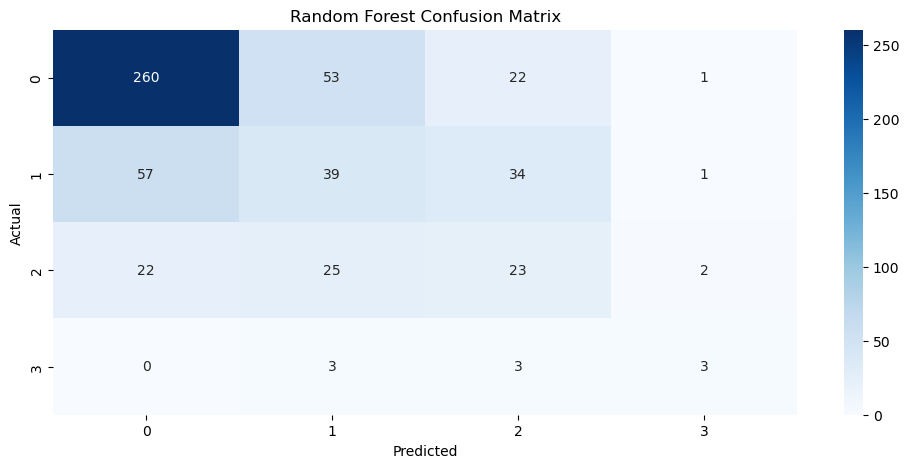

In [47]:
# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model_balanced, X_train, y_train, cv=5, scoring='accuracy')
print("\nRandom Forest Cross-Validation Accuracy Scores:", rf_cv_scores)
print("Random Forest Mean Cross-Validation Accuracy:", np.mean(rf_cv_scores))

# Fit the Random Forest model
rf_model_balanced.fit(X_train_selected, y_train)

# Make predictions on the test set
rf_predictions = rf_model_balanced.predict(X_test_selected)

# Evaluate the models using the test set
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_predictions))

# Plot Confusion Matrices for Test Set
plt.figure(figsize=(12, 5))

# Random Forest Confusion Matrix
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, cmap='Blues', fmt='g')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [48]:
# # Step 8: Modeling with Random Forest and Gradient Boosting (with class weight adjustment)
# # Define Random Forest and Gradient Boosting models with class weight adjustment
# gb_model_balanced = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=3, subsample=0.8, random_state=42)

# # Hyperparameter tuning for Gradient Boosting
# param_grid_gb = {
#     'n_estimators': [2, 3, 4, 5],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'max_depth': [3, 4, 5],
#     'subsample': [0.6, 0.8, 1.0],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# gb_random_search = RandomizedSearchCV(gb_model_balanced, param_distributions=param_grid_gb, n_iter=10, cv=3, random_state=42, n_jobs=-1, scoring='accuracy', verbose = 2)
# gb_random_search.fit(X_train_selected, y_train)

# print(gb_random_search.best_estimator_)

# # Best model after hyperparameter tuning
# gb_model_balanced = gb_random_search.best_estimator_



# ### Best Parameters Gradient Boosting
# #GradientBoostingClassifier(learning_rate=0.3, max_depth=5, min_samples_leaf=4,
# #                           min_samples_split=10, n_estimators=200,
# #                           random_state=42, subsample=0.8)

In [49]:
# best model after hyperparameter tuning (from previous run)
gb_model_balanced = GradientBoostingClassifier(n_estimators=4, learning_rate=0.2, max_depth=3, subsample=0.8, random_state=42)


Gradient Boosting Cross-Validation Accuracy Scores: [0.60873883 0.64349553 0.65109344 0.68986083 0.6610338 ]
Gradient Boosting Mean Cross-Validation Accuracy: 0.6508444862108382

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.70      0.73       336
         1.0       0.33      0.31      0.32       131
         2.0       0.23      0.28      0.25        72
         3.0       0.12      0.44      0.19         9

    accuracy                           0.55       548
   macro avg       0.36      0.43      0.37       548
weighted avg       0.58      0.55      0.56       548



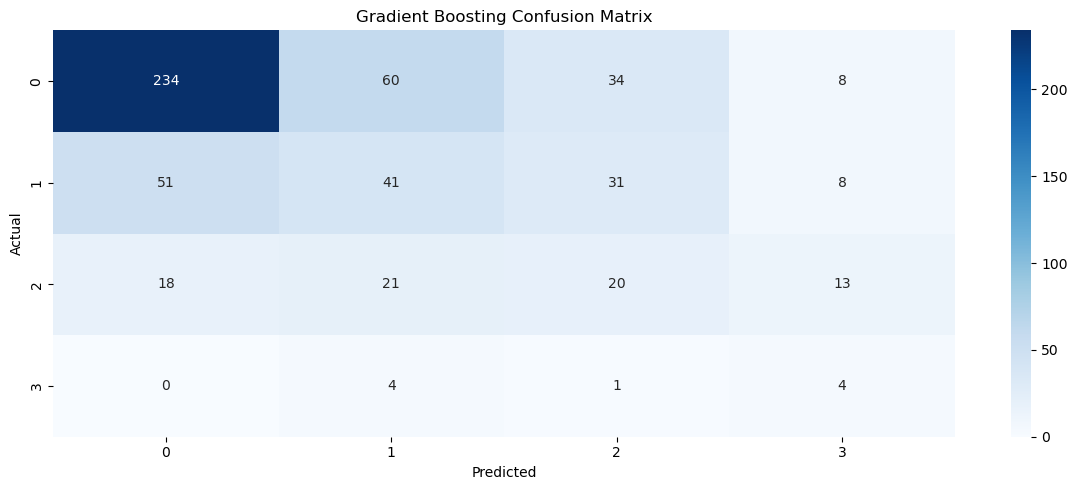

In [50]:
# Cross-validation for Gradient Boosting
gb_cv_scores = cross_val_score(gb_model_balanced, X_train, y_train, cv=5, scoring='accuracy')
print("\nGradient Boosting Cross-Validation Accuracy Scores:", gb_cv_scores)
print("Gradient Boosting Mean Cross-Validation Accuracy:", np.mean(gb_cv_scores))

# Fit the Gradient Boosting model
gb_model_balanced.fit(X_train_selected, y_train)

# Make predictions on the test set
gb_predictions = gb_model_balanced.predict(X_test_selected)

# Evaluate the models using the test set
print("\nGradient Boosting Classification Report:\n", classification_report(y_test, gb_predictions))

# Plot Confusion Matrices for Test Set
plt.figure(figsize=(12, 5))

# Gradient Boosting Confusion Matrix
sns.heatmap(confusion_matrix(y_test, gb_predictions), annot=True, cmap='Blues', fmt='g')
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [51]:
# Make predictions on the test set
rf_predictions = rf_model_balanced.predict(test_data[selected_features])
gb_predictions = gb_model_balanced.predict(test_data[selected_features])

# Evaluate the models using the test set
rf_siis = rf_predictions.tolist()
gb_siis = gb_predictions.tolist()

print(f"The random forest siis are {rf_siis}")
print(f"The gradient boost siis are {gb_siis}")

The random forest siis are [2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0]
The gradient boost siis are [0.0, 0.0, 1.0, 0.0, 3.0, 3.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0]


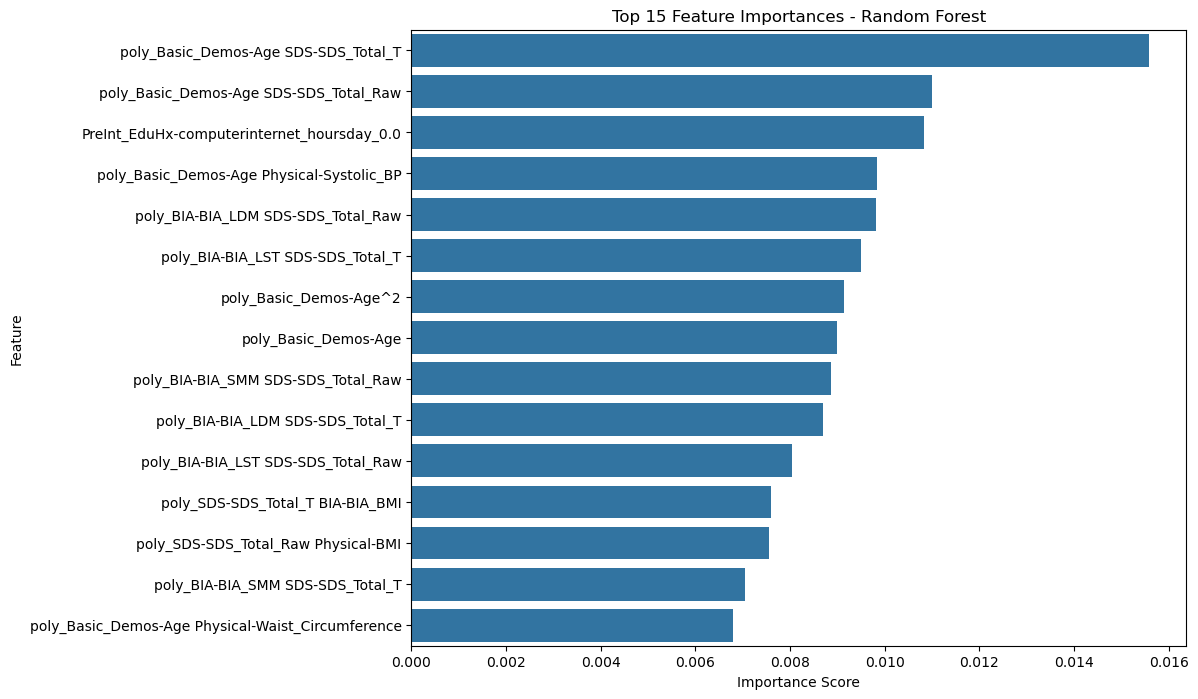

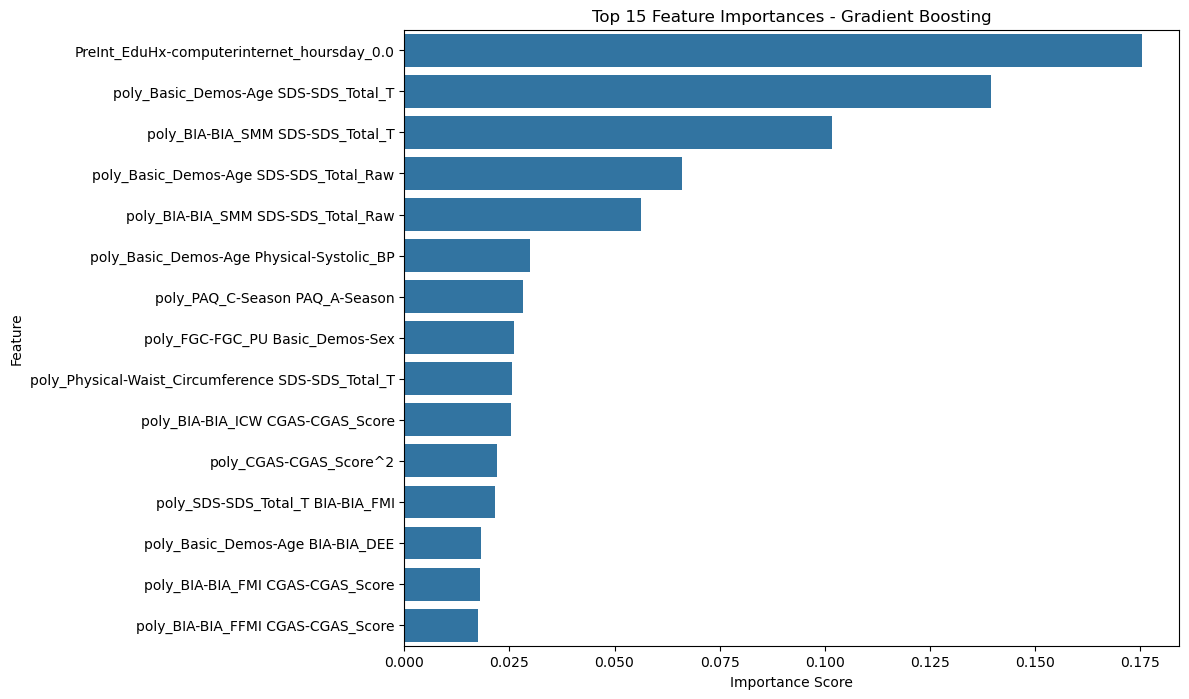

In [52]:
# Step 9: Feature Importance Visualization
# Get feature importances from the trained Random Forest and Gradient Boosting models
importances_rf = rf_model_balanced.feature_importances_
importances_gb = gb_model_balanced.feature_importances_

# Creating a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'RandomForest Importance': importances_rf,
    'GradientBoosting Importance': importances_gb
})

# Sorting the features by importance for RandomForest
feature_importance_df_sorted_rf = feature_importance_df.sort_values(by='RandomForest Importance', ascending=False)

# Plotting feature importance for RandomForest
plt.figure(figsize=(10, 8))
sns.barplot(x='RandomForest Importance', y='Feature', data=feature_importance_df_sorted_rf.head(15))
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Sorting the features by importance for Gradient Boosting
feature_importance_df_sorted_gb = feature_importance_df.sort_values(by='GradientBoosting Importance', ascending=False)

# Plotting feature importance for Gradient Boosting
plt.figure(figsize=(10, 8))
sns.barplot(x='GradientBoosting Importance', y='Feature', data=feature_importance_df_sorted_gb.head(15))
plt.title('Top 15 Feature Importances - Gradient Boosting')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()
